In [334]:
import pandas as pd
import numpy as np

# Imported PyTorch libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data import random_split

import matplotlib.pyplot as plt

# All images stored in CNN_Data/CNN
# Collected by Carlie

In [335]:
import os

DATA_DIR = "CNN_Data/CNN"   # <-- change this if your folder is different

for class_name in os.listdir(DATA_DIR):
    class_path = os.path.join(DATA_DIR, class_name)

    # Only process folders
    if os.path.isdir(class_path):
        num_images = len([
            f for f in os.listdir(class_path)
            if f.lower().endswith((".jpg", ".jpeg", ".png"))
        ])

        print(f"{class_name}: {num_images} images")


official_razorback: 30 images
other: 30 images


In [336]:
import torchvision.transforms as transforms

IMG_SIZE = 500  # Resize all images to 500x500 pixels

def get_transforms(use_normalization: bool):
    # Define data augmentation and normalization transforms
    if use_normalization:
        train_transform = transforms.Compose([
            transforms.Resize((IMG_SIZE, IMG_SIZE)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomRotation(10),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])

        test_transform = transforms.Compose([
            transforms.Resize((IMG_SIZE, IMG_SIZE)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])
        
    else:
        # try without normalization
        train_transform = transforms.Compose([
            transforms.Resize((IMG_SIZE, IMG_SIZE)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomRotation(10),
            transforms.ToTensor(),
        ])

        test_transform = transforms.Compose([
            transforms.Resize((IMG_SIZE, IMG_SIZE)),
            transforms.ToTensor(),
        ])

    return train_transform, test_transform


In [337]:
from torchvision import datasets
from torch.utils.data import DataLoader, random_split

DATA_DIR = "CNN_Data/CNN"
BATCH_SIZE = 32
TRAIN_SPLIT = 0.8
RANDOM_SEED = 40

def make_loaders(use_normalization: bool):
    train_transform, test_transform = get_transforms(use_normalization)

    full_dataset = datasets.ImageFolder(DATA_DIR, transform=train_transform)
    num_classes = len(full_dataset.classes)

    train_size = int(TRAIN_SPLIT * len(full_dataset))
    test_size = len(full_dataset) - train_size

    torch.manual_seed(RANDOM_SEED)
    train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

    # important: set test transform on the underlying dataset
    test_dataset.dataset.transform = test_transform

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    return train_loader, test_loader, num_classes, full_dataset.classes


In [338]:
# Clara
# Define baseline CNN model. No frills.
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        
        # Layer 1: Find basic features (edges, colors)
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        
        # Layer 2: Find more complex patterns
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        
        # Layer 3: Find even more detail
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        
        # Layer 4: Combine everything to make predictions
        self.fc1 = nn.Linear(128 * 62 * 62, 256)
        self.fc2 = nn.Linear(256, num_classes)
        
        # Dropout to prevent overfitting
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        # Pass through conv layer 1
        x = self.pool(F.relu(self.conv1(x)))  # 500->250
        
        # Pass through conv layer 2
        x = self.pool(F.relu(self.conv2(x)))  # 250->125
        
        # Pass through conv layer 3
        x = self.pool(F.relu(self.conv3(x)))  # 125->62
        
        # Flatten
        x = x.view(-1, 128 * 62 * 62)
        
        # Final classification layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x

In [339]:
# Clara
# Create the model
model = SimpleCNN(num_classes=num_classes)

In [340]:
# Clara
# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
print(f"Using device: {device}")

Using device: cpu


In [341]:
# Clara
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [342]:
def train_one_model(use_normalization: bool, num_epochs: int = 10):
    print("\n==============================")
    print(f"Experiment: use_normalization = {use_normalization}")
    print("==============================")

    train_loader, test_loader, num_classes, class_names = make_loaders(use_normalization)

    # fresh model & optimizer each time
    model = SimpleCNN(num_classes=num_classes).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = 100.0 * correct / total
        print(f"Epoch {epoch+1}/{num_epochs} "
              f"- Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")

    # final test evaluation
    model.eval()
    test_correct = 0
    test_total = 0
    test_loss = 0.0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            test_total += labels.size(0)
            test_correct += (preds == labels).sum().item()

    test_loss /= len(test_loader)
    test_acc = 100.0 * test_correct / test_total
    print(f"Test - Loss: {test_loss:.4f}, Acc: {test_acc:.2f}% "
          f"({test_correct}/{test_total})")

    return model, (train_loss, train_acc), (test_loss, test_acc)


In [343]:
model_no_norm, _, _ = train_one_model(use_normalization=False, num_epochs=10)
model_norm,   _, _ = train_one_model(use_normalization=True,  num_epochs=10)



Experiment: use_normalization = False
Epoch 1/10 - Train Loss: 1.4150, Train Acc: 50.00%
Epoch 2/10 - Train Loss: 12.2480, Train Acc: 52.08%
Epoch 3/10 - Train Loss: 1.5173, Train Acc: 50.00%
Epoch 4/10 - Train Loss: 1.0016, Train Acc: 41.67%
Epoch 5/10 - Train Loss: 0.6596, Train Acc: 60.42%
Epoch 6/10 - Train Loss: 0.6390, Train Acc: 62.50%
Epoch 7/10 - Train Loss: 0.6528, Train Acc: 58.33%
Epoch 8/10 - Train Loss: 0.5408, Train Acc: 70.83%
Epoch 9/10 - Train Loss: 0.4443, Train Acc: 85.42%
Epoch 10/10 - Train Loss: 0.4286, Train Acc: 89.58%
Test - Loss: 0.5687, Acc: 66.67% (8/12)

Experiment: use_normalization = True
Epoch 1/10 - Train Loss: 3.8219, Train Acc: 58.33%
Epoch 2/10 - Train Loss: 12.8062, Train Acc: 50.00%
Epoch 3/10 - Train Loss: 3.4013, Train Acc: 52.08%
Epoch 4/10 - Train Loss: 0.6458, Train Acc: 72.92%
Epoch 5/10 - Train Loss: 0.4007, Train Acc: 77.08%
Epoch 6/10 - Train Loss: 0.3137, Train Acc: 87.50%
Epoch 7/10 - Train Loss: 0.2209, Train Acc: 89.58%
Epoch 8/10 - 

In [348]:

def imshow(img, used_norm=False):
    img = img.cpu().numpy().transpose((1, 2, 0))  # C,H,W -> H,W,C

    if used_norm:
        # Undo ImageNet normalization
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = img * std + mean

    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.axis("off")


def show_test_predictions(model, test_loader, classes, used_norm=False, num_images=12):
    model.eval()
    images_shown = 0

    plt.figure(figsize=(15, 10))

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            for i in range(images.size(0)):
                if images_shown == num_images:
                    return

                plt.subplot(num_images // 4 + 1, 4, images_shown + 1)
                imshow(images[i], used_norm=used_norm)

                true_label = classes[labels[i].item()]
                pred_label = classes[preds[i].item()]

                plt.title(f"P: {pred_label}\nT: {true_label}", fontsize=10)
                images_shown += 1





In [350]:
# For model WITHOUT normalization
train_loader_no_norm, test_loader_no_norm, num_classes, class_names = make_loaders(use_normalization=False)

# For model WITH normalization
train_loader_norm, test_loader_norm, _, _ = make_loaders(use_normalization=True)


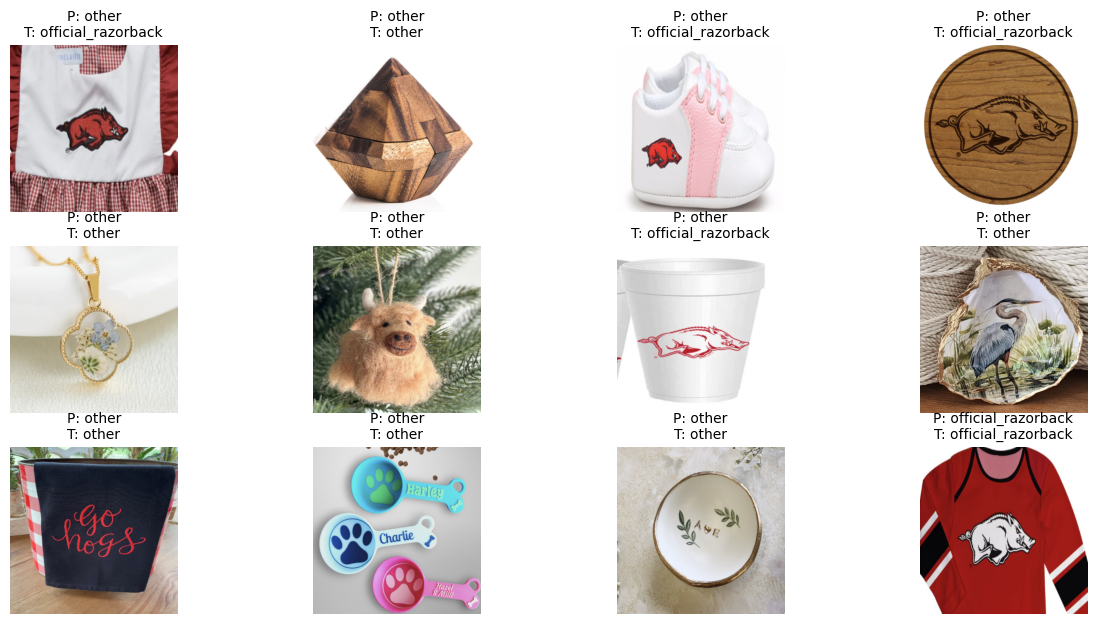

In [351]:
show_test_predictions(
    model_no_norm,
    test_loader_no_norm,
    dataset.classes,
    used_norm=False,
    num_images=12
)
plt.show()



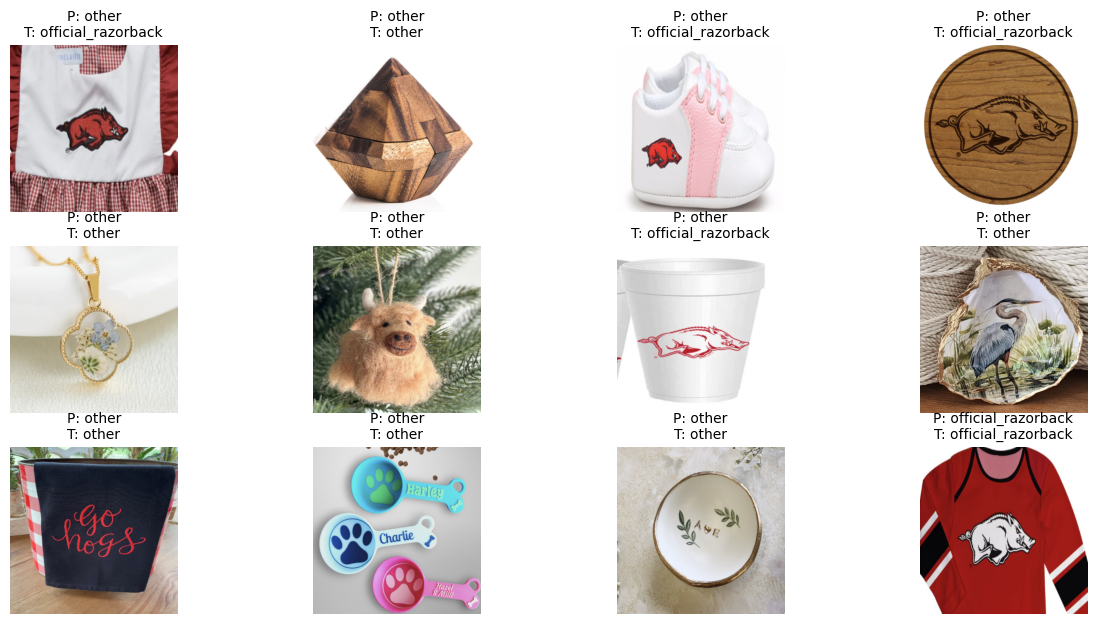

In [352]:
show_test_predictions(
    model_no_norm,
    test_loader_no_norm,
    dataset.classes,
    used_norm=False,
    num_images=12
)
plt.show()


In [299]:
# Clara
# A generic resizing function that resizes images appropriately in 500 x 500
# transform = transforms.Compose([
#     transforms.Resize((500, 500)),
#     transforms.ToTensor()
# ])

In [300]:
# Carlie try and normalize images 

IMG_SIZE = 500  

train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.ToTensor(),
    # ImageNet normalization (rough but usually fine if you don't know dataset stats)
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])


In [301]:

DATA_DIR = "CNN_Data/CNN"

full_train_dataset = datasets.ImageFolder(DATA_DIR, transform=train_transform)
num_classes = len(full_train_dataset.classes)

# Split
train_size = int(0.75 * len(full_train_dataset))
test_size = len(full_train_dataset) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(full_train_dataset, [train_size, test_size])

# IMPORTANT: override test transform (random_split will copy the same underlying dataset)
test_dataset.dataset.transform = test_transform


In [302]:
# Clara
# # Adjust dataset based upon specifications of the project.
#dataset = datasets.ImageFolder('CNN_Data/CNN', transform=transform)

In [303]:
# Clara
# Grab number of classes within the dataset based on the directory structure
# num_classes = len(dataset.classes)
# print(f"{num_classes} classes: {dataset.classes}")
# print(f"Total images: {len(dataset)}")

In [304]:
# Clara
# Utilizing an 80/20 training-test split, mostly because of the small dataset size.
# train_size = int(0.8 * len(dataset))
# test_size = len(dataset) - train_size
# train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

In [305]:
# Clara
# Create dataloaders based on the train and test datasets.
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [306]:
# Clara
# Print the quantities of images.
# Training is super close to 50, which is nice.
print(f"Training images: {train_size}")
print(f"Testing images: {test_size}\n")

Training images: 45
Testing images: 15



In [307]:
# Clara
# Define baseline CNN model. No frills.
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        
        # Layer 1: Find basic features (edges, colors)
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        
        # Layer 2: Find more complex patterns
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        
        # Layer 3: Find even more detail
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        
        # Layer 4: Combine everything to make predictions
        self.fc1 = nn.Linear(128 * 62 * 62, 256)
        self.fc2 = nn.Linear(256, num_classes)
        
        # Dropout to prevent overfitting
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        # Pass through conv layer 1
        x = self.pool(F.relu(self.conv1(x)))  # 500->250
        
        # Pass through conv layer 2
        x = self.pool(F.relu(self.conv2(x)))  # 250->125
        
        # Pass through conv layer 3
        x = self.pool(F.relu(self.conv3(x)))  # 125->62
        
        # Flatten
        x = x.view(-1, 128 * 62 * 62)
        
        # Final classification layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x
    


In [308]:
# Clara
# Create the model
model = SimpleCNN(num_classes=num_classes)

In [309]:
# Clara
# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
print(f"Using device: {device}")

Using device: cpu


In [310]:
# Clara
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [311]:
# Define the training function
def train(num_epochs=15):
    # Train CNN
    model.train()
    
    for epoch in range(num_epochs):
        total_loss = 0
        correct = 0
        total = 0
        
        for batch_num, (images, labels) in enumerate(train_loader):
            # Move data to GPU/CPU
            images = images.to(device)
            labels = labels.to(device)
            
            # Clear previous gradients
            optimizer.zero_grad()
            
            # Make predictions
            outputs = model(images)
            
            # Calculate loss
            loss = criterion(outputs, labels)
            
            # Update weights
            loss.backward()
            optimizer.step()
            
            # Track accuracy
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        # Print results for this epoch
        avg_loss = total_loss / len(train_loader)
        accuracy = 100 * correct / total
        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_loss:.4f}, Train Accuracy: {accuracy:.2f}%")

In [312]:
# Clara
# Train the model. Observe that the accuracies aren't bad.
train()

Epoch 1/15 - Train Loss: 4.0396, Train Accuracy: 55.56%
Epoch 2/15 - Train Loss: 10.4316, Train Accuracy: 48.89%
Epoch 3/15 - Train Loss: 1.0815, Train Accuracy: 53.33%
Epoch 4/15 - Train Loss: 0.4184, Train Accuracy: 80.00%
Epoch 5/15 - Train Loss: 0.7941, Train Accuracy: 60.00%
Epoch 6/15 - Train Loss: 0.2943, Train Accuracy: 91.11%
Epoch 7/15 - Train Loss: 0.2824, Train Accuracy: 91.11%
Epoch 8/15 - Train Loss: 0.2755, Train Accuracy: 91.11%
Epoch 9/15 - Train Loss: 0.1085, Train Accuracy: 97.78%
Epoch 10/15 - Train Loss: 0.1034, Train Accuracy: 95.56%
Epoch 11/15 - Train Loss: 0.2293, Train Accuracy: 80.00%
Epoch 12/15 - Train Loss: 0.1436, Train Accuracy: 93.33%
Epoch 13/15 - Train Loss: 0.0599, Train Accuracy: 100.00%
Epoch 14/15 - Train Loss: 0.0465, Train Accuracy: 100.00%
Epoch 15/15 - Train Loss: 0.0187, Train Accuracy: 100.00%


In [313]:
# Clara
# Test model now.
def test():

    # Set to evaluation mode
    model.eval()
    
    correct = 0
    total = 0
    test_loss = 0
    
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    avg_loss = test_loss / len(test_loader)
    accuracy = 100 * correct / total
    
    print("Test:")
    print(f"Test Loss: {avg_loss:.4f}")
    print(f"Test Accuracy: {accuracy:.2f}%")
    print(f"Correct: {correct}/{total}")

In [314]:
# Clara
# Test
test()

Test:
Test Loss: 0.5957
Test Accuracy: 86.67%
Correct: 13/15


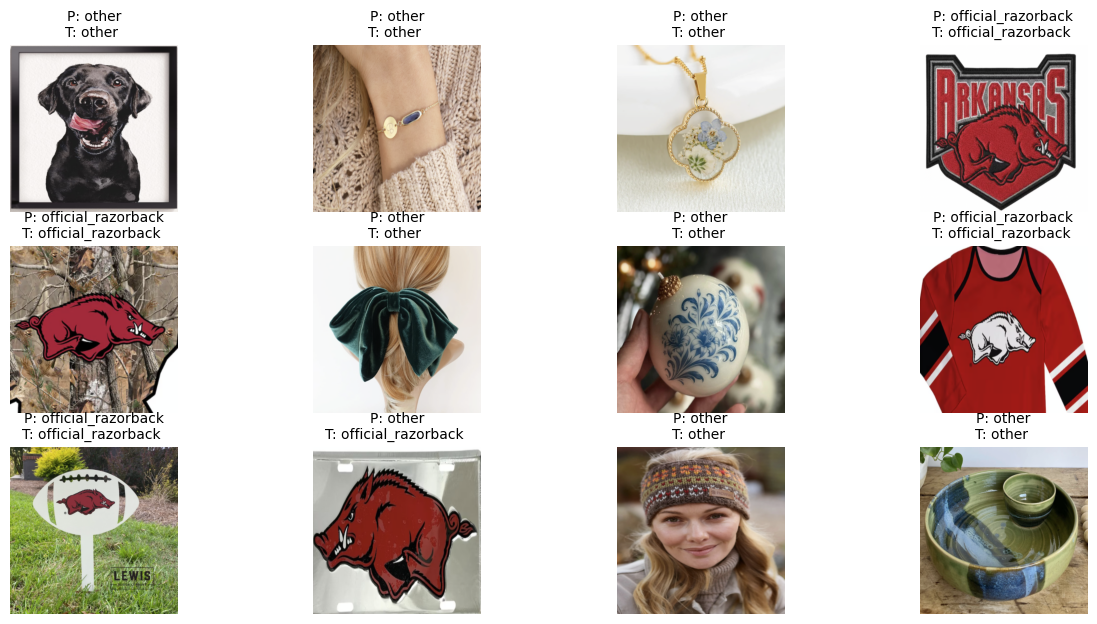

In [315]:


# Function to show images
def imshow(img):
    img = img.cpu().numpy().transpose((1, 2, 0))  # C,H,W -> H,W,C
    # Undo normalization if you used it
    img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.axis("off")

def show_test_predictions(model, test_loader, classes, num_images=12):
    model.eval()
    images_shown = 0

    plt.figure(figsize=(15, 10))

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            # Loop through the batch
            for i in range(images.size(0)):
                if images_shown == num_images:
                    return

                plt.subplot(num_images//4 + 1, 4, images_shown + 1)
                imshow(images[i])

                true_label = classes[labels[i].item()]
                pred_label = classes[preds[i].item()]

                

                plt.title(f"P: {pred_label}\nT: {true_label} ", fontsize=10)
                images_shown += 1

# Call it!
show_test_predictions(model, test_loader, dataset.classes, num_images=12)
plt.show()
